In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import random
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np


In [5]:
#Confirming GPU activation with TensorFlow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
data_dir = 'dataset'
img_size = (524, 524)   #can be reduced for faster training
batch_size = 8          #can be reduced for faster training
seed = 42

In [3]:
classes = os.listdir(data_dir)

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
max_count = max(class_counts.values())
print("Max class size to match:", max_count)


Max class size to match: 921


In [4]:
aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    current_images = os.listdir(class_path)
    current_count = len(current_images)
    
    while current_count < max_count:
        img_name = random.choice(current_images)
        img_path = os.path.join(class_path, img_name)

        # Load and preprocess image
        image = load_img(img_path, target_size=img_size)
        image = img_to_array(image)
        image = np.expand_dims(image, 0)

        # Create augmented image
        aug_iter = aug.flow(image, batch_size=1)
        aug_img = next(aug_iter)[0].astype('uint8')

        # Save augmented image
        new_filename = f"aug_{current_count}_{img_name}"
        aug_img_path = os.path.join(class_path, new_filename)
        tf.keras.preprocessing.image.save_img(aug_img_path, aug_img)

        current_count += 1

In [6]:
#Dividing into Training and Validation Datasets (80-20)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 8289 files belonging to 9 classes.
Using 6632 files for training.
Found 8289 files belonging to 9 classes.
Using 1657 files for validation.


In [7]:
#Class Names

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [8]:
#Rescaling pixel values from 0-1

normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
#CNN Architecture

def build_custom_cnn(input_shape=(524, 524, 3), num_classes=9):
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))  # 524 -> 262

    # Conv Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))  # 262 -> 131

    # Conv Block 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))  # 131 -> 65

    # Conv Block 4
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))  # 65 -> 32

    # Global Pooling & Dense
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))  # -> 9

    return model

model = build_custom_cnn(input_shape=(524, 524, 3), num_classes=num_classes)

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 524, 524, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 524, 524, 32)     128       


 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 262, 262, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 262, 262, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 262, 262, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 131, 131, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 131, 131, 128)     73856     
                                                                 
 batch_nor

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
829/829 [==============================] - 159s 181ms/step - loss: 1.6316 - accuracy: 0.4100 - val_loss: 2.1563 - val_accuracy: 0.3530
Epoch 2/30
829/829 [==============================] - 151s 182ms/step - loss: 1.3949 - accuracy: 0.5050 - val_loss: 3.7118 - val_accuracy: 0.2112
Epoch 3/30
829/829 [==============================] - 152s 183ms/step - loss: 1.2396 - accuracy: 0.5531 - val_loss: 1.5769 - val_accuracy: 0.4786
Epoch 4/30
829/829 [==============================] - 150s 181ms/step - loss: 1.1454 - accuracy: 0.5951 - val_loss: 5.1663 - val_accuracy: 0.1473
Epoch 5/30
829/829 [==============================] - 152s 183ms/step - loss: 1.0330 - accuracy: 0.6294 - val_loss: 2.3747 - val_accuracy: 0.3639
Epoch 6/30
829/829 [==============================] - 152s 183ms/step - loss: 0.9738 - accuracy: 0.6508 - val_loss: 2.0646 - val_accuracy: 0.4363
Epoch 7/30
829/829 [==============================] - 152s 183ms/step - loss: 0.8883 - accuracy: 0.6806 - val_loss: 4.5673 -

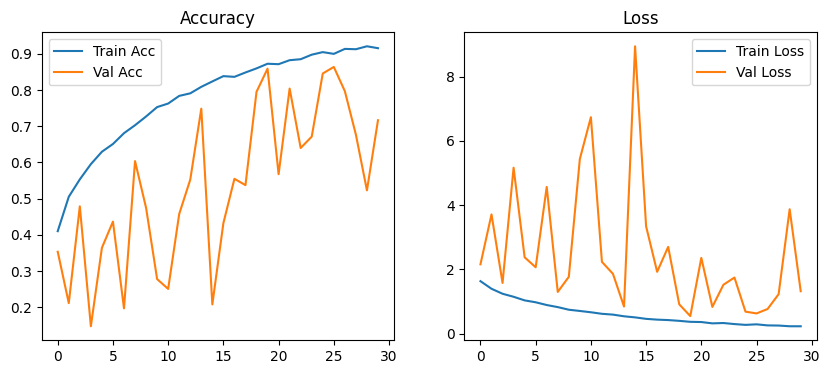

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [21]:
model.save('custom_cnn_model_tf.keras')

In [ ]:
model = keras.models.load_model('custom_cnn_model_tf.keras')

In [19]:
loss, accuracy = model.evaluate(train_ds)
print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy:.4f}")

loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

829/829 [==============================] - 53s 64ms/step - loss: 0.9571 - accuracy: 0.7685
Training Loss: 0.9571
Training Accuracy: 0.7685
208/208 [==============================] - 13s 63ms/step - loss: 1.3182 - accuracy: 0.7164
Validation Loss: 1.3182
Validation Accuracy: 0.7164


To increase Validation Accuracy and reduce Validation Loss-

1. Add more filters to each convolution layer, to extract more precise features

2. Train for more epochs

3. Reduce Dropout rate